<a href="https://colab.research.google.com/github/Savio-Jos3/Major-Pro/blob/main/Geographic_Route_Finder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point

# --- 1. Configuration ---
# Set the location to analyze. Using your location as an example.
place_name = "Kochi, Kerala, India"
# Download the street network for the specified location. 'drive' network is for cars.
G = ox.graph_from_place(place_name, network_type='drive')

# Define points of interest using (latitude, longitude)
# Note: These are example coordinates. You can find real ones on Google Maps.
start_point = (9.96, 76.28) # Example: Near Fort Kochi
safe_zone = (9.99, 76.31)   # Example: A designated safe area
threat_locations = [
    (9.97, 76.29),         # Example: Threat 1
    (9.98, 76.285)         # Example: Threat 2
]

THREAT_RADIUS_METERS = 500  # How far a threat's influence extends
RISK_FACTOR = 10            # How much to penalize roads near threats

# --- 2. Helper Functions ---

def add_risk_to_graph(G, threats, radius, risk_factor):
    """
    Modifies the graph by increasing the 'weight' of edges near threat locations.
    The A* algorithm uses this 'weight' attribute to calculate the path cost.
    """
    G_proj = ox.project_graph(G)

    # Create a new attribute 'risk' and 'weight' for each edge
    for u, v, data in G.edges(data=True):
        data['risk'] = 0
        data['weight'] = data['length']

    print(f"Applying risk factor of {risk_factor}x within a {radius}m radius of threats...")
    for threat_coord in threats:
        # Project the threat coordinate to the graph's CRS
        threat_point_proj = ox.project_point(threat_coord, G_proj.graph['crs'])

        # Find all edges within the threat radius
        edges_within_radius = []
        for u, v, key, data in G_proj.edges(keys=True, data=True):
            # Check if either the start or end node of the edge is near the threat
            if Point(data['geometry'].coords[0]).distance(threat_point_proj) < radius or \
               Point(data['geometry'].coords[-1]).distance(threat_point_proj) < radius:
                edges_within_radius.append((u, v, key))

        # Increase the weight of the affected edges in the original graph
        for u, v, key in edges_within_radius:
            edge_data = G.get_edge_data(u, v, key)
            if edge_data:
                original_length = edge_data['length']
                edge_data['risk'] = 1 # Mark as a risky edge
                edge_data['weight'] = original_length * risk_factor

    return G

# --- 3. Main Execution ---

if __name__ == "__main__":
    # Add risk zones to the graph based on threat locations
    G_risk = add_risk_to_graph(G.copy(), threat_locations, THREAT_RADIUS_METERS, RISK_FACTOR)

    # Find the nearest network nodes to our points of interest
    start_node = ox.nearest_nodes(G_risk, start_point[1], start_point[0])
    safe_node = ox.nearest_nodes(G_risk, safe_zone[1], safe_zone[0])

    print("Calculating safest route using A* algorithm...")
    try:
        # Use networkx's A* algorithm to find the path
        # It uses the 'weight' attribute we created, which includes the risk penalty
        safest_route_nodes = nx.astar_path(G_risk, start_node, safe_node, weight='weight')
        print("Route found successfully!")
    except nx.NetworkXNoPath:
        print("Could not find a route to the safe zone. It might be unreachable.")
        safest_route_nodes = None

    # --- 4. Visualization ---

    # Get the colors for the plot based on edge risk
    edge_colors = []
    for u, v, data in G_risk.edges(data=True):
        if data.get('risk', 0) == 1:
            edge_colors.append('red')
        else:
            edge_colors.append('gray')

    # Define colors for the route and points of interest
    route_color = 'lime'
    threat_color = 'red'
    start_color = 'green'
    end_color = 'blue'

    # Plot the graph, threats, and the calculated route
    if safest_route_nodes:
        fig, ax = ox.plot_graph_route(
            G_risk,
            safest_route_nodes,
            route_color=route_color,
            route_linewidth=6,
            node_size=0,
            bgcolor='k',
            edge_color=edge_colors,
            edge_linewidth=0.5,
            show=False, close=False
        )
    else:
        # Plot just the graph and threats if no route is found
        fig, ax = ox.plot_graph(
            G_risk,
            node_size=0,
            bgcolor='k',
            edge_color=edge_colors,
            edge_linewidth=0.5,
            show=False, close=False
        )

    # Add markers for start, end, and threat points
    ax.scatter(start_point[1], start_point[0], c=start_color, s=200, label='Start Point', marker='o')
    ax.scatter(safe_zone[1], safe_zone[0], c=end_color, s=200, label='Safe Zone', marker='s')
    for i, threat in enumerate(threat_locations):
        ax.scatter(threat[1], threat[0], c=threat_color, s=400, label=f'Threat {i+1}', marker='x')

    ax.set_title("Evacuation Route Analysis", fontsize=16)
    plt.legend()
    plt.show()

Applying risk factor of 10x within a 500m radius of threats...


AttributeError: module 'osmnx' has no attribute 'project_point'

In [6]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
from pyproj import Transformer

# --- 1. Configuration ---
# Set the location to analyze. Using your location as an example.
place_name = "Kochi, Kerala, India"
# Download the street network for the specified location. 'drive' network is for cars.
G = ox.graph_from_place(place_name, network_type='drive')

# Define points of interest using (latitude, longitude)
# Note: These are example coordinates. You can find real ones on Google Maps.
start_point = (9.96, 76.28) # Example: Near Fort Kochi
safe_zone = (9.99, 76.31)   # Example: A designated safe area
threat_locations = [
    (9.97, 76.29),         # Example: Threat 1
    (9.98, 76.285)         # Example: Threat 2
]

THREAT_RADIUS_METERS = 500  # How far a threat's influence extends
RISK_FACTOR = 10            # How much to penalize roads near threats

# --- 2. Helper Functions ---

def add_risk_to_graph(G, threats, radius, risk_factor):
    """
    Modifies the graph by increasing the 'weight' of edges near threat locations.
    The A* algorithm uses this 'weight' attribute to calculate the path cost.
    """
    # Project the graph to a local UTM zone for accurate distance calculations
    G_proj = ox.project_graph(G)

    # Get the Coordinate Reference System (CRS) from the projected graph
    graph_crs = G_proj.graph['crs']

    # Create a transformer to convert from lat/lon (EPSG:4326) to the graph's local CRS
    transformer = Transformer.from_crs("epsg:4326", graph_crs, always_xy=True)

    # Create a new attribute 'risk' and 'weight' for each edge, initializing them
    for u, v, data in G.edges(data=True):
        data['risk'] = 0
        data['weight'] = data['length']

    print(f"Applying risk factor of {risk_factor}x within a {radius}m radius of threats...")
    for threat_coord in threats:
        # Project the threat coordinate (lon, lat) to the graph's projected CRS (x, y)
        threat_lon, threat_lat = threat_coord[1], threat_coord[0]
        threat_x, threat_y = transformer.transform(threat_lon, threat_lat)
        threat_point_proj = Point(threat_x, threat_y)

        # Find all edges within the threat radius using the projected graph
        edges_within_radius = []
        for u, v, key, data in G_proj.edges(keys=True, data=True):
            # The geometry of the edge is a LineString, already in projected coordinates
            edge_line = data['geometry']

            # Check if the minimum distance from the road to the threat is within the radius
            if edge_line.distance(threat_point_proj) < radius:
                edges_within_radius.append((u, v, key))

        # Increase the weight of the affected edges in the original graph
        for u, v, key in edges_within_radius:
            edge_data = G.get_edge_data(u, v, key)
            if edge_data:
                original_length = edge_data['length']
                edge_data['risk'] = 1 # Mark as a risky edge
                edge_data['weight'] = original_length * risk_factor

    return G

# --- 3. Main Execution ---

if __name__ == "__main__":
    # Add risk zones to the graph based on threat locations
    G_risk = add_risk_to_graph(G.copy(), threat_locations, THREAT_RADIUS_METERS, RISK_FACTOR)

    # Find the nearest network nodes to our points of interest
    start_node = ox.nearest_nodes(G_risk, start_point[1], start_point[0])
    safe_node = ox.nearest_nodes(G_risk, safe_zone[1], safe_zone[0])

    print("Calculating safest route using A* algorithm...")
    try:
        # Use networkx's A* algorithm to find the path
        # It uses the 'weight' attribute we created, which includes the risk penalty
        safest_route_nodes = nx.astar_path(G_risk, start_node, safe_node, weight='weight')
        print("Route found successfully!")
    except nx.NetworkXNoPath:
        print("Could not find a route to the safe zone. It might be unreachable.")
        safest_route_nodes = None

    # --- 4. Visualization ---

    # Get the colors for the plot based on edge risk
    edge_colors = []
    for u, v, data in G_risk.edges(data=True):
        if data.get('risk', 0) == 1:
            edge_colors.append('red')
        else:
            edge_colors.append('gray')

    # Define colors for the route and points of interest
    route_color = 'lime'
    threat_color = 'red'
    start_color = 'green'
    end_color = 'blue'

    # Plot the graph, threats, and the calculated route
    if safest_route_nodes:
        fig, ax = ox.plot_graph_route(
            G_risk,
            safest_route_nodes,
            route_color=route_color,
            route_linewidth=6,
            node_size=0,
            bgcolor='k',
            edge_color=edge_colors,
            edge_linewidth=0.5,
            show=False, close=False
        )
    else:
        # Plot just the graph and threats if no route is found
        fig, ax = ox.plot_graph(
            G_risk,
            node_size=0,
            bgcolor='k',
            edge_color=edge_colors,
            edge_linewidth=0.5,
            show=False, close=False
        )

    # Add markers for start, end, and threat points
    ax.scatter(start_point[1], start_point[0], c=start_color, s=200, label='Start Point', marker='o')
    ax.scatter(safe_zone[1], safe_zone[0], c=end_color, s=200, label='Safe Zone', marker='s')
    for i, threat in enumerate(threat_locations):
        ax.scatter(threat[1], threat[0], c=threat_color, s=400, label=f'Threat {i+1}', marker='x')

    ax.set_title("Evacuation Route Analysis", fontsize=16)
    plt.legend()
    plt.show()



Applying risk factor of 10x within a 500m radius of threats...


KeyError: 'geometry'

In [4]:
!pip install osmnx shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 4.0 MB/s eta 0:00:00


In [7]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
from pyproj import Transformer

# --- 1. Configuration ---
# Set the location to analyze. Using your location as an example.
place_name = "Kochi, Kerala, India"
# Download the street network for the specified location. 'drive' network is for cars.
G = ox.graph_from_place(place_name, network_type='drive')

# Define points of interest using (latitude, longitude)
# Note: These are example coordinates. You can find real ones on Google Maps.
start_point = (9.96, 76.28) # Example: Near Fort Kochi
safe_zone = (9.99, 76.31)   # Example: A designated safe area
threat_locations = [
    (9.97, 76.29),         # Example: Threat 1
    (9.98, 76.285)         # Example: Threat 2
]

THREAT_RADIUS_METERS = 500  # How far a threat's influence extends
RISK_FACTOR = 10            # How much to penalize roads near threats

# --- 2. Helper Functions ---

def add_risk_to_graph(G, threats, radius, risk_factor):
    """
    Modifies the graph by increasing the 'weight' of edges near threat locations.
    The A* algorithm uses this 'weight' attribute to calculate the path cost.
    """
    # Project the graph to a local UTM zone for accurate distance calculations
    G_proj = ox.project_graph(G)

    # Get the Coordinate Reference System (CRS) from the projected graph
    graph_crs = G_proj.graph['crs']

    # Create a transformer to convert from lat/lon (EPSG:4326) to the graph's local CRS
    transformer = Transformer.from_crs("epsg:4326", graph_crs, always_xy=True)

    # Create a new attribute 'risk' and 'weight' for each edge, initializing them
    for u, v, data in G.edges(data=True):
        data['risk'] = 0
        data['weight'] = data['length']

    print(f"Applying risk factor of {risk_factor}x within a {radius}m radius of threats...")
    for threat_coord in threats:
        # Project the threat coordinate (lon, lat) to the graph's projected CRS (x, y)
        threat_lon, threat_lat = threat_coord[1], threat_coord[0]
        threat_x, threat_y = transformer.transform(threat_lon, threat_lat)
        threat_point_proj = Point(threat_x, threat_y)

        # Find all edges within the threat radius using the projected graph
        edges_within_radius = []
        for u, v, key, data in G_proj.edges(keys=True, data=True):
            # The geometry of the edge is a LineString, already in projected coordinates
            edge_line = data['geometry']

            # Check if the minimum distance from the road to the threat is within the radius
            if edge_line.distance(threat_point_proj) < radius:
                edges_within_radius.append((u, v, key))

        # Increase the weight of the affected edges in the original graph
        for u, v, key in edges_within_radius:
            edge_data = G.get_edge_data(u, v, key)
            if edge_data:
                original_length = edge_data['length']
                edge_data['risk'] = 1 # Mark as a risky edge
                edge_data['weight'] = original_length * risk_factor

    return G

# --- 3. Main Execution ---

if __name__ == "__main__":
    # Add risk zones to the graph based on threat locations
    G_risk = add_risk_to_graph(G.copy(), threat_locations, THREAT_RADIUS_METERS, RISK_FACTOR)

    # Find the nearest network nodes to our points of interest
    start_node = ox.nearest_nodes(G_risk, start_point[1], start_point[0])
    safe_node = ox.nearest_nodes(G_risk, safe_zone[1], safe_zone[0])

    print("Calculating safest route using A* algorithm...")
    try:
        # Use networkx's A* algorithm to find the path
        # It uses the 'weight' attribute we created, which includes the risk penalty
        safest_route_nodes = nx.astar_path(G_risk, start_node, safe_node, weight='weight')
        print("Route found successfully!")
    except nx.NetworkXNoPath:
        print("Could not find a route to the safe zone. It might be unreachable.")
        safest_route_nodes = None

    # --- 4. Visualization ---

    # Get the colors for the plot based on edge risk
    edge_colors = []
    for u, v, data in G_risk.edges(data=True):
        if data.get('risk', 0) == 1:
            edge_colors.append('red')
        else:
            edge_colors.append('gray')

    # Define colors for the route and points of interest
    route_color = 'lime'
    threat_color = 'red'
    start_color = 'green'
    end_color = 'blue'

    # Plot the graph, threats, and the calculated route
    if safest_route_nodes:
        fig, ax = ox.plot_graph_route(
            G_risk,
            safest_route_nodes,
            route_color=route_color,
            route_linewidth=6,
            node_size=0,
            bgcolor='k',
            edge_color=edge_colors,
            edge_linewidth=0.5,
            show=False, close=False
        )
    else:
        # Plot just the graph and threats if no route is found
        fig, ax = ox.plot_graph(
            G_risk,
            node_size=0,
            bgcolor='k',
            edge_color=edge_colors,
            edge_linewidth=0.5,
            show=False, close=False
        )

    # Add markers for start, end, and threat points
    ax.scatter(start_point[1], start_point[0], c=start_color, s=200, label='Start Point', marker='o')
    ax.scatter(safe_zone[1], safe_zone[0], c=end_color, s=200, label='Safe Zone', marker='s')
    for i, threat in enumerate(threat_locations):
        ax.scatter(threat[1], threat[0], c=threat_color, s=400, label=f'Threat {i+1}', marker='x')

    ax.set_title("Evacuation Route Analysis", fontsize=16)
    plt.legend()
    plt.show()



Applying risk factor of 10x within a 500m radius of threats...


KeyError: 'geometry'

Applying risk factor of 10x within a 500m radius of threats...
Calculating safest route using A* algorithm...
Route found successfully!


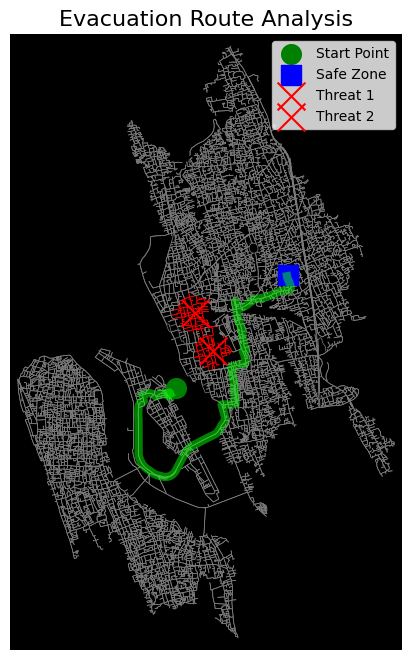

In [8]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
from pyproj import Transformer

# --- 1. Configuration ---
# Set the location to analyze. Using your location as an example.
place_name = "Kochi, Kerala, India"
# Download the street network for the specified location. 'drive' network is for cars.
G = ox.graph_from_place(place_name, network_type='drive')

# Define points of interest using (latitude, longitude)
# Note: These are example coordinates. You can find real ones on Google Maps.
start_point = (9.96, 76.28) # Example: Near Fort Kochi
safe_zone = (9.99, 76.31)   # Example: A designated safe area
threat_locations = [
    (9.97, 76.29),         # Example: Threat 1
    (9.98, 76.285)         # Example: Threat 2
]

THREAT_RADIUS_METERS = 500  # How far a threat's influence extends
RISK_FACTOR = 10            # How much to penalize roads near threats

# --- 2. Helper Functions ---

def add_risk_to_graph(G, threats, radius, risk_factor):
    """
    Modifies the graph by increasing the 'weight' of edges near threat locations.
    The A* algorithm uses this 'weight' attribute to calculate the path cost.
    """
    # Project the graph to a local UTM zone for accurate distance calculations
    G_proj = ox.project_graph(G)

    # Get the Coordinate Reference System (CRS) from the projected graph
    graph_crs = G_proj.graph['crs']

    # Create a transformer to convert from lat/lon (EPSG:4326) to the graph's local CRS
    transformer = Transformer.from_crs("epsg:4326", graph_crs, always_xy=True)

    # Create a new attribute 'risk' and 'weight' for each edge, initializing them
    for u, v, data in G.edges(data=True):
        data['risk'] = 0
        data['weight'] = data['length']

    # Convert the projected graph's edges to a GeoDataFrame to reliably access geometry
    edges_proj_gdf = ox.graph_to_gdfs(G_proj, nodes=False)

    print(f"Applying risk factor of {risk_factor}x within a {radius}m radius of threats...")
    for threat_coord in threats:
        # Project the threat coordinate (lon, lat) to the graph's projected CRS (x, y)
        threat_lon, threat_lat = threat_coord[1], threat_coord[0]
        threat_x, threat_y = transformer.transform(threat_lon, threat_lat)
        threat_point_proj = Point(threat_x, threat_y)

        # Find all edges within the threat radius using the projected GeoDataFrame
        # The index of the GeoDataFrame contains (u, v, key)
        edges_within_radius_indices = edges_proj_gdf[edges_proj_gdf.distance(threat_point_proj) < radius].index

        # Increase the weight of the affected edges in the original graph
        for u, v, key in edges_within_radius_indices:
            edge_data = G.get_edge_data(u, v, key)
            if edge_data:
                original_length = edge_data['length']
                edge_data['risk'] = 1 # Mark as a risky edge
                edge_data['weight'] = original_length * risk_factor

    return G

# --- 3. Main Execution ---

if __name__ == "__main__":
    # Add risk zones to the graph based on threat locations
    G_risk = add_risk_to_graph(G.copy(), threat_locations, THREAT_RADIUS_METERS, RISK_FACTOR)

    # Find the nearest network nodes to our points of interest
    start_node = ox.nearest_nodes(G_risk, start_point[1], start_point[0])
    safe_node = ox.nearest_nodes(G_risk, safe_zone[1], safe_zone[0])

    print("Calculating safest route using A* algorithm...")
    try:
        # Use networkx's A* algorithm to find the path
        # It uses the 'weight' attribute we created, which includes the risk penalty
        safest_route_nodes = nx.astar_path(G_risk, start_node, safe_node, weight='weight')
        print("Route found successfully!")
    except nx.NetworkXNoPath:
        print("Could not find a route to the safe zone. It might be unreachable.")
        safest_route_nodes = None

    # --- 4. Visualization ---

    # Get the colors for the plot based on edge risk
    edge_colors = []
    for u, v, data in G_risk.edges(data=True):
        if data.get('risk', 0) == 1:
            edge_colors.append('red')
        else:
            edge_colors.append('gray')

    # Define colors for the route and points of interest
    route_color = 'lime'
    threat_color = 'red'
    start_color = 'green'
    end_color = 'blue'

    # Plot the graph, threats, and the calculated route
    if safest_route_nodes:
        fig, ax = ox.plot_graph_route(
            G_risk,
            safest_route_nodes,
            route_color=route_color,
            route_linewidth=6,
            node_size=0,
            bgcolor='k',
            edge_color=edge_colors,
            edge_linewidth=0.5,
            show=False, close=False
        )
    else:
        # Plot just the graph and threats if no route is found
        fig, ax = ox.plot_graph(
            G_risk,
            node_size=0,
            bgcolor='k',
            edge_color=edge_colors,
            edge_linewidth=0.5,
            show=False, close=False
        )

    # Add markers for start, end, and threat points
    ax.scatter(start_point[1], start_point[0], c=start_color, s=200, label='Start Point', marker='o')
    ax.scatter(safe_zone[1], safe_zone[0], c=end_color, s=200, label='Safe Zone', marker='s')
    for i, threat in enumerate(threat_locations):
        ax.scatter(threat[1], threat[0], c=threat_color, s=400, label=f'Threat {i+1}', marker='x')

    ax.set_title("Evacuation Route Analysis", fontsize=16)
    plt.legend()
    plt.show()

